# Code For: Experimentally Comparing Reinforcement Learning Algorithms with Finite-Time Optimality Guarantees

Contributors: Andrew Lee, Nathan Ng, Sam Poulin, Rose Zhang, and Fivos Kalogiannis 

## Setup Game

Before implementing the Reinforcement Learning algorithms, we first implement a version of Gridworld to test the algorithms on and define constants in.

We first begin with the necessary inputs for the rest of the code:

In [335]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Arrow, Circle
from itertools import product
from multiprocessing import Pool
from tqdm import tqdm
from collections import namedtuple

We then construct a class that allows us to store and represent a Grid World, alongside some requisite parameters:

In [317]:
class Gridworld:
    def __init__(self, w, h, gamma, rho = None):
        self.RX = w
        self.RY = h
        self.NSTATES = w*h
        self.NACTIONS = 5

        self.gamma = gamma

        if rho is None:
            self.rho = np.zeros(self.NSTATES)
            self.rho[0] = 1.0
        else:
            self.rho = rho

        #setup transition matrix:
        self.P = np.zeros( (self.RY, self.RX, self.NACTIONS, self.RY, self.RX) )
        for idx in range(self.RY*self.RX):
            x = idx % self.RX
            y = idx // self.RX
            for a in range(self.NACTIONS):
                ny, nx = self.move(y, x, a)
                ny = np.clip(ny, 0, self.RY-1)
                nx = np.clip(nx, 0, self.RX-1)
                self.P[y, x, a, ny, nx] = 1

        R = np.zeros((self.RY, self.RX, self.NACTIONS))
        self.R = R.reshape(self.RY*self.RX, self.NACTIONS)
    
    def set_reward(self, x, y, val):
        self.R = self.R.reshape(self.RY, self.RX, self.NACTIONS)
        if x not in range(0, self.RX) or y not in range(0, self.RY):
            return
        self.R[y, x, 1] = val
        if y-1 in range(0, self.RY):
            self.R[y-1, x, 3] = val
        if y+1 in range(0, self.RY): 
            self.R[y+1, x, 4] = val
        if x-1 in range(0, self.RX): 
            self.R[y, x-1, 2] = val
        if x+1 in range(0, self.RX):
            self.R[y, x+1, 0] = val
        self.R = self.R.reshape(self.RY*self.RX, self.NACTIONS)

    def move(self, y, x, a):
        if a == 0:
            x -= 1
            return y, x
        elif a == 1:
            return y, x
        elif a == 2:
            x += 1
            return y, x
        elif a == 3:
            y += 1
            return y, x
        elif a == 4:
            y -= 1
            return y, x

## Projected Gradient Ascent

From there, we are able to implement a Projected Gradient Ascent Reinforcement Learning algorithm to solve this implementation of Grid World.

We begin by defining functions used when calculating the value and gradient of a given policy for each step of the Projected Gradient algorithm:

In [318]:
def get_d(gamma, Ptheta):
    sz = np.shape(Ptheta)
    return np.linalg.inv(np.eye(*sz) - gamma * Ptheta)

def get_V(gw, policy, d):
    #print(np.shape(policy))
    #print(np.shape(gw.R))
    r_expect = np.sum(policy * gw.R, axis=1)
    V = np.zeros(gw.NSTATES)
    V = d.dot(r_expect)
    #print(V.shape)
    return V

def get_Q(gw, policy, d):
    V = get_V(gw, policy, d)
    return gw.R + gw.gamma * np.einsum( 'ijk,k->ij', gw.P.reshape( gw.NSTATES, gw.NACTIONS, gw.NSTATES) , V )

def get_Ptheta2D(P, policy, gw):
    Pprime = P.reshape(gw.NSTATES * gw.NACTIONS, gw.NSTATES) * policy.reshape(gw.NSTATES * gw.NACTIONS)[:, None]
    Ptheta = np.zeros((gw.NSTATES, gw.NSTATES))

    for s in range(gw.NSTATES):
        z = np.sum( Pprime[s*gw.NACTIONS:(s+1)*gw.NACTIONS, :], axis=0 )
        Ptheta[s, :] = z
    return Ptheta

def get_direct_grad(gw, policy):
    Ptheta = get_Ptheta2D(gw.P, policy, gw)
    d = get_d(gw.gamma, Ptheta)
    V = get_V(gw, policy, d)
    q = get_Q(gw, policy, d)
    grad = (1/(1 - gw.gamma)) * gw.rho.dot(d)[:, None] * q
    return grad

We then implement an algorithm for projecting onto a simplex described by Yunmei Chen and Xiaojing Ye ([arXiv:1101.6081](https://arxiv.org/abs/1101.6081)) to ensure that each state in a policy describes a valid probability distribution.

In [319]:
def projsplx(y):
    """
    Python implementation of:
    https://arxiv.org/abs/1101.6081
    """
    s = np.sort(y)
    n = len(y) ; flag = False

    parsum = 0
    tmax = -np.inf
    for idx in range(n-2, -1, -1):
        parsum += s[idx+1]
        tmax = (parsum - 1) / (n - (idx + 1) )
        if tmax >= s[idx]:
            flag = True ; break

    if not flag:
        tmax = (np.sum(s) - 1) / n

    return np.maximum(y - tmax, 0)

def policy_projsplx(policy):
    new_pol = np.zeros_like(policy)
    for idx, row in enumerate(policy):
        new_pol[idx, :] = projsplx(row.flatten())
    return new_pol

Finally, we use the functions defined above to implement a Projected Gradient Ascent Reinforcement Learning algorithm.

In [392]:
def meets_termination_condition(prev_val, curr_val, curr_grad, epsilon = 1e-20):
    return (
        # used to prevent the bad clase where we get a values near 0 early on
        not(curr_val) < 0.1 and (

            # 2 of the four conditions described in Mykel J. Kochenderfer and Tim A. Wheeler section 4.5
            # (max iterations is handled in algorithms themselves, gradient found to lead to strange behavior)
            abs(prev_val - curr_val) < epsilon or
            abs(prev_val - curr_val) < epsilon * abs(curr_val)
            
        )
    ) 

def projected_gradient_ascent(gw, T = 1000, eta = 0.3):
    policy = np.random.rand(gw.RY, gw.RX, gw.NACTIONS)
    policy = policy.reshape(gw.RY*gw.RX, gw.NACTIONS)

    for idx, row in enumerate(policy):
        policy[idx, :] = projsplx(row.flatten())

    Vs = []
    for _ in range(T + 1):
        # get current value (done first so we get the value of the initial policy)
        ptheta = get_Ptheta2D(gw.P, policy, gw)
        d = get_d(gw.gamma, ptheta)
        V = get_V(gw, policy, d)
        Vs.append(gw.rho.dot(V))
        
        # test whether we've met the termination condition
        grad = get_direct_grad(gw, policy)
        if len(Vs) > 1 and meets_termination_condition(Vs[-2], Vs[-1], grad):
            # repeat the code to match the length of if it ran the entire time
            if len(Vs) < T:
                Vs += [Vs[-1] for _ in range(T - len(Vs) + 1)]
            break

        # iteration step
        policy = policy + eta * grad
        for idx, row in enumerate(policy):
            policy[idx, :] = projsplx(row.flatten())

    return policy, Vs

## Entropy Regularized Softmax Policy Gradient

From equations (15)-(19): 
$$
    \frac{\partial \tilde V^{\pi_\theta}(\mu)}{\partial \theta (s, a)} = \frac{1}{(1-\gamma)} \cdot d^{\pi_\theta}_{\mu}(s) \cdot \pi_\theta(a|s) \cdot \tilde A^{\pi_\theta}(s,a) \\
    \tilde A^{\pi_\theta}(s,a) := \tilde Q^{\pi_\theta}(s,a) - \tau \log \pi_\theta (a|s) - \tilde V^{\pi_\theta}(s) \\
    \tilde Q^{\pi_\theta}(s,a) := r(s, a) + \gamma \sum_{s'} \mathcal{P}(s'|s, a) \tilde V^{\pi_\theta}(s') \\
    \tilde V^{\pi} := V^\pi (\rho) + \tau \cdot \mathbb{H}(\rho, \pi) \\
    \mathbb{H}(\rho, \pi) := \underset{\substack{s_0 \sim \rho, \ a_t \sim \pi(\cdot|s_t),\\s_{t+1} \sim \mathcal{P}(\cdot | s_t, a_t)}}{\mathbb{E}} \left[ \sum_{t=0}^{\infty} -\gamma^{t} \log \pi(a_t|s_t) \right]
$$

In [321]:
def entropy(x):
    eps = 1e-20
    return -np.sum([xi*np.log(xi+eps) for xi in x])

def discounted_entropy(policy, gw, d):
    state_entropies = np.apply_along_axis(entropy, 1, policy)
    return -np.sum(d * state_entropies)

def softmax(x):
    exp_vals = np.exp(np.float128(x))
    return np.float64(exp_vals/np.sum(exp_vals))
    

In [322]:
def get_V_tilde(gw, policy, d, temperature):
    val_term = gw.rho.dot(get_V(gw, policy, d))
    ent_term = temperature * discounted_entropy(policy, gw, d)
    return get_V(gw, policy, d) + temperature * discounted_entropy(policy, gw, d)

def get_Q_tilde(gw, policy, d, temperature):
    P, R = gw.P, gw.R
    V = get_V_tilde(gw, policy, d, temperature)
    return R + gw.gamma * np.einsum( 'ijk,k->ij', P.reshape( gw.NSTATES, gw.NACTIONS, gw.NSTATES) , V )

def get_A_tilde(gw, policy, temperature, d):
    eps = 1e-20
    ot = ((get_Q_tilde(gw, policy, d, temperature) - temperature * np.log(policy+eps)).transpose() - get_V_tilde(gw, policy, d, temperature)).transpose()
    return ((get_Q_tilde(gw, policy, d, temperature) - temperature * np.log(policy+eps)).transpose() - get_V_tilde(gw, policy, d, temperature)).transpose()

def get_grad_V_tilde(gw, policy, temperature):
    Ptheta = get_Ptheta2D(gw.P, policy, gw)
    d = get_d(gw.gamma, Ptheta)
    return ((1 / (1 - gw.gamma)) * gw.rho.dot(d).T * (policy * get_A_tilde(gw, policy, temperature, d)).T).T

In [396]:
def entropy_softmax_gradient_ascent(gw, T = 1000, eta = 0.1, temp = 0.05):
    # logits = np.ones((gw.RY, gw.RX, gw.NACTIONS))
    logits = (np.random.rand(gw.RY, gw.RX, gw.NACTIONS))
    logits = logits.reshape(gw.RY*gw.RX, gw.NACTIONS)
    policy = np.apply_along_axis(softmax, 1, logits)

    Vs = []
    for t in range(T + 1):
        # get current value (done first so we get the value of the initial policy)
        ptheta = get_Ptheta2D(gw.P, policy, gw)
        d = get_d(gw.gamma, ptheta)
        V = get_V(gw, policy, d)
        Vs.append(gw.rho.dot(V))

        # test whether we've met the termination condition
        grad = get_grad_V_tilde(gw, policy, temp)
        if len(Vs) > 1 and meets_termination_condition(Vs[-2], Vs[-1], grad):
            if len(Vs) < T:
                Vs += [Vs[-1] for _ in range(T - len(Vs) + 1)]
            if Vs[-1] < 50:
                print(Vs)
            break

        # iteration step
        logits = logits + eta * grad
        policy = np.apply_along_axis(softmax, 1, logits)

    return policy, Vs

## Testing the Implementations
Having implemented both algorithms, we can now move to testing them.

We first begin with testing code that, given a grid world, plots how the algorithms behave over the learning process:

In [384]:
def test_algorithms(gw: Gridworld, T = 1_000, num_tests = 50):
    # record variables
    gradient_ascent_policies = []
    gradient_ascent_values_over_learning = []
    entropy_softmax_policies = []
    entropy_softmax_values_over_learning = []

    # do learning
    for _ in range(num_tests):
        policy, value = projected_gradient_ascent(gw, T)
        gradient_ascent_policies.append(policy)
        gradient_ascent_values_over_learning.append(value)
        plt.plot(value, 'b')

        policy, value = entropy_softmax_gradient_ascent(gw, T)
        entropy_softmax_policies.append(policy)
        entropy_softmax_values_over_learning.append(value)
        plt.plot(value, 'r')

    # display initial plot
    plt.show()

    # display average plot (andrew: not sure that this is actually meaningful)
    plt.figure()
    x = np.linspace(0, T + 1, T + 1)
    ga_mean = np.mean(gradient_ascent_values_over_learning, axis = 0)
    ga_std_dev = np.std(gradient_ascent_values_over_learning, axis = 0, dtype=np.float64)
    esga_mean = np.mean(entropy_softmax_values_over_learning, axis = 0)
    esga_std_dev = np.std(entropy_softmax_values_over_learning, axis = 0, dtype=np.float64)
    # plt.fill_between(x, ga_mean + ga_std_dev, ga_mean - ga_std_dev, alpha=0.5, facecolor='blue')
    # plt.fill_between(x, esga_mean + esga_std_dev, esga_mean - esga_std_dev, alpha=0.5, facecolor='red')
    plt.plot(ga_mean, 'b')
    plt.plot(esga_mean, 'r')
    plt.show()

    return gradient_ascent_policies, entropy_softmax_policies

We can then test the two algorithms, beginning with a very simple $4 \times 4$ Grid World with a reward in the opposite corner.

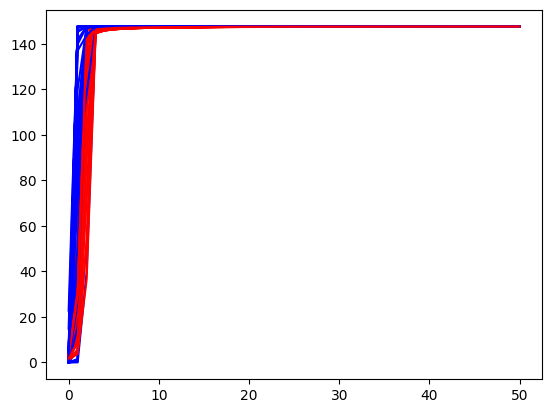

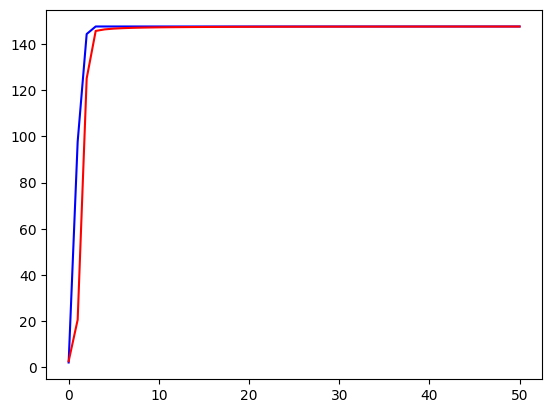

In [390]:
gw = Gridworld(4, 4, 0.9)
gw.set_reward(3, 3, 25)

ga_policies, es_policies = test_algorithms(gw, 50)

We also test their performance given a much larger grid world to work from with a not-insubstantial penalty

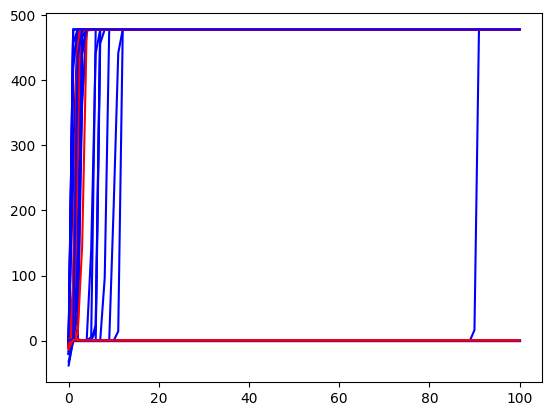

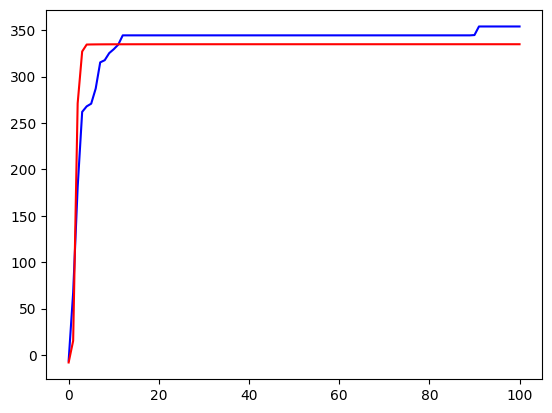

In [397]:
gw = Gridworld(5, 5, 0.9)
gw.set_reward(2, 2, -50)
gw.set_reward(4, 4, 100)

ga_policies, es_policies = test_algorithms(gw, 100)
plt.show()

...

/tmp/ipykernel_63787/377693411.py:10: RuntimeWarning: overflow encountered in exp
  exp_vals = np.exp(np.float128(x))
/tmp/ipykernel_63787/377693411.py:11: RuntimeWarning: invalid value encountered in divide
  return np.float64(exp_vals/np.sum(exp_vals))


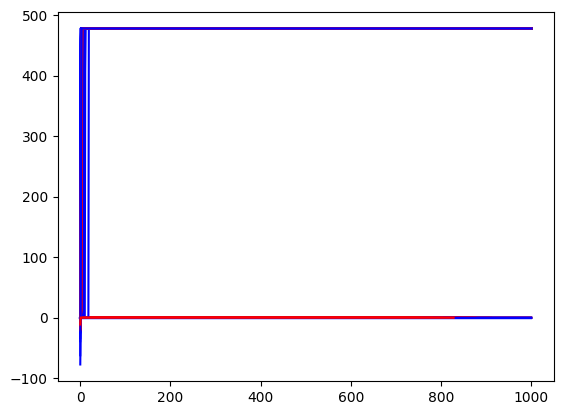

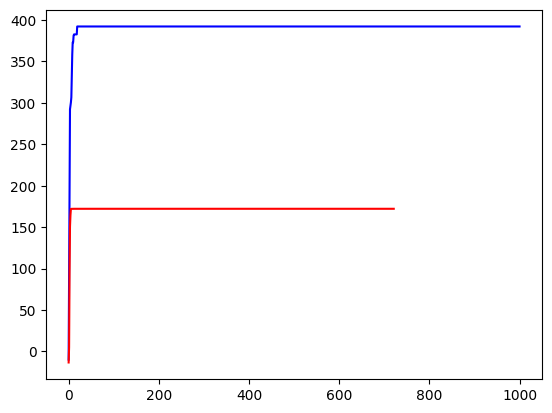

In [398]:
gw = Gridworld(5, 5, 0.9)
gw.set_reward(2, 2, -75)
gw.set_reward(4, 4, 100)

ga_policies, es_policies = test_algorithms(gw)
plt.show()

In this case, we not only expand the size of the GridWorld and add a few small rewards but also include a potential saddle point along the way.

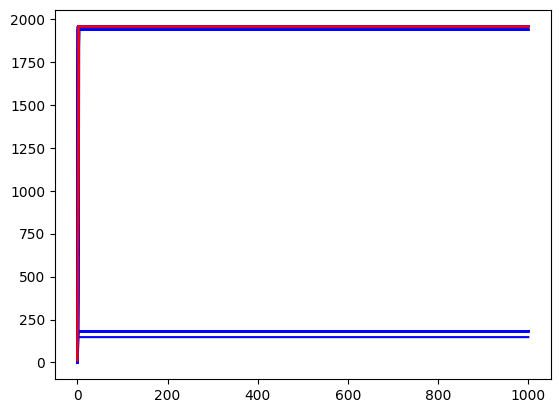

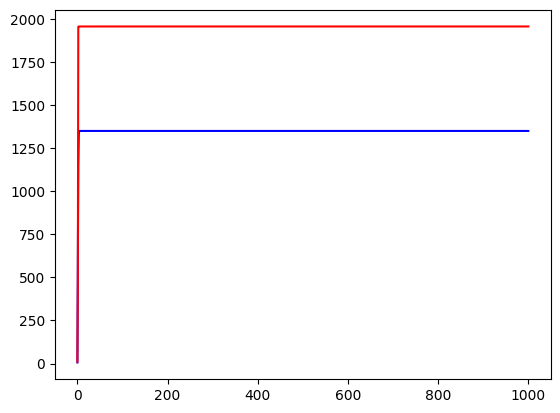

In [399]:
gw = Gridworld(6, 6, 0.9)
gw.set_reward(4, 2, -1)
gw.set_reward(2, 2, 25)
gw.set_reward(3, 3, 1)
gw.set_reward(5, 5, 500)

ga_policies, es_policies = test_algorithms(gw)
plt.show()

---
## Other Code

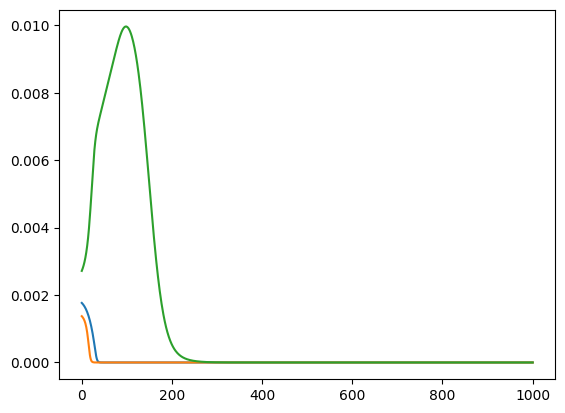

In [ ]:
gw = Gridworld(6, 3, 0.5)
gw.set_reward(4, 2, 10)

for _ in range(3):
    policy, values = entropy_softmax_gradient_ascent(gw)
    plt.plot(values)

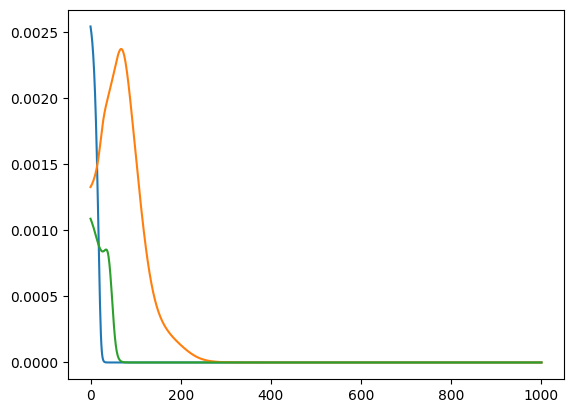

In [ ]:
gw = Gridworld(6, 3, 0.5)
gw.set_reward(4, 2, 10)

for _ in range(3):
    policy, values = entropy_softmax_gradient_ascent(gw)
    plt.plot(values)

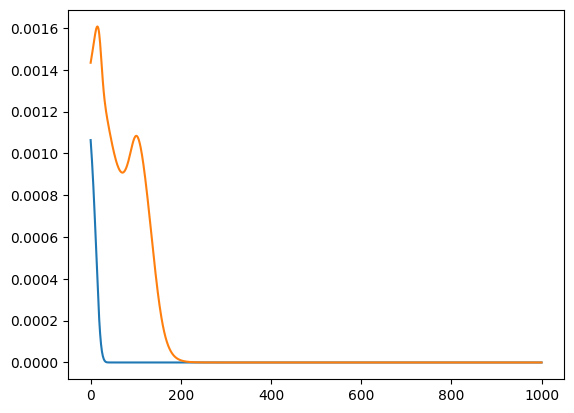

In [ ]:
gw = Gridworld(6, 3, 0.5)
gw.set_reward(4, 2, 10)

for _ in range(2):
    policy, values = entropy_softmax_gradient_ascent(gw)
    plt.plot(values)